# Discretização de Controladores PI e PID

## Da Função de Transferência Contínua H(s) à Equação de Diferenças

**Objetivo:** Este notebook detalha o processo de conversão de controladores analógicos ideais (PI e PID), definidos no domínio de Laplace $H(s)$, para suas formas digitais equivalentes $H(z)$.

O objetivo final é obter a **Equação de Diferenças**, que é o algoritmo exato que pode ser programado em um microcontrolador (em C, Python, etc.) para ser executado a cada período de amostragem $T$.

### O Processo de Discretização

O processo sempre segue três etapas:
1.  **$H(s)$:** Definir o controlador ideal no domínio contínuo (Laplace).
2.  **$H(z)$:** Aplicar uma "regra de substituição" (aproximação) para converter $s \to z$.
3.  **Equação de Diferenças:** Converter $H(z) = Y(z)/E(z)$ em uma equação de tempo discreto $y[k]$ que relaciona a saída atual com amostras passadas.

Vamos analisar o impacto dos três métodos de aproximação mais comuns:
* **Backward Euler (Aproximação Atrasada)**
* **Forward Euler (Aproximação Avançada)**
* **Tustin (Transformada Bilinear / Regra do Trapézio)**

## Capítulo 1: O Controlador Proporcional-Integral (PI)

O "cavalo de batalha" do controle industrial. Sua forma contínua ideal (paralela) é:

$$
H(s) = \frac{Y(s)}{E(s)} = K_p + \frac{K_i}{s}
$$

Onde $E(s)$ é o erro (`Referência - Leitura Sensor`) e $Y(s)$ é a saída do controlador. Nosso objetivo é encontrar a equação de diferenças $y[k] = f(y[k-n], e[k-n])$.

### 1.1 Aproximação Backward Euler (Atrasada)

Este é o método mais simples e robusto. Ele aproxima a derivada ($\frac{dy}{dt}$) usando a amostra atual e a amostra passada: $\frac{y[k] - y[k-1]}{T}$.

A regra de substituição para o integrador ($1/s$) é o inverso disso:

**Regra de Substituição:** $s \approx \frac{1 - z^{-1}}{T}$

**Passo 1: Substituir $s$ em $H(s)$**
$$
H(z) = K_p + \frac{K_i}{ \left( \frac{1 - z^{-1}}{T} \right) }
$$

**Passo 2: Simplificar para obter $H(z)$**
$$
H(z) = K_p + \frac{K_i T}{1 - z^{-1}}
$$
Colocando sob um denominador comum:
$$
H(z) = \frac{K_p (1 - z^{-1})}{1 - z^{-1}} + \frac{K_i T}{1 - z^{-1}}
$$
$$
H(z) = \frac{Y(z)}{E(z)} = \frac{(K_p + K_i T) - K_p z^{-1}}{1 - z^{-1}}
$$

**Passo 3: Encontrar a Equação de Diferenças**
Começamos com a FT $H(z) = Y(z)/E(z)$ e fazemos a multiplicação cruzada:
$$
Y(z) \cdot (1 - z^{-1}) = E(z) \cdot [ (K_p + K_i T) - K_p z^{-1} ]
$$
Distribuímos os termos:
$$
Y(z) - Y(z)z^{-1} = E(z)(K_p + K_i T) - E(z)z^{-1} K_p
$$
Agora, convertemos do domínio-Z para o domínio do tempo discreto ($k$), lembrando que $z^{-1}$ é um operador de atraso de uma amostra:
* $Y(z) \to y[k]$ (saída atual)
* $Y(z)z^{-1} \to y[k-1]$ (saída passada)
* $E(z) \to e[k]$ (erro atual)
* $E(z)z^{-1} \to e[k-1]$ (erro passado)

A equação se torna:
$$
y[k] - y[k-1] = e[k](K_p + K_i T) - e[k-1] K_p
$$

**Passo 4: A Equação de Diferenças Final (Backward Euler)**
Isolando $y[k]$, obtemos o algoritmo final:

$$
y[k] = y[k-1] + (K_p + K_i T)e[k] - K_p e[k-1]
$$

### 1.2 Aproximação Forward Euler (Avançada)

Este método aproxima a derivada usando a amostra atual e a *próxima* amostra: $\frac{y[k+1] - y[k]}{T}$.

**Regra de Substituição:** $s \approx \frac{z - 1}{T}$

**Passo 1: Substituir $s$ em $H(s)$**
$$
H(z) = K_p + \frac{K_i}{ \left( \frac{z - 1}{T} \right) }
$$

**Passo 2: Simplificar para obter $H(z)$**
$$
H(z) = K_p + \frac{K_i T}{z - 1}
$$
Colocando sob um denominador comum:
$$
H(z) = \frac{K_p (z - 1)}{z - 1} + \frac{K_i T}{z - 1}
$$
$$
H(z) = \frac{Y(z)}{E(z)} = \frac{K_p z + (K_i T - K_p)}{z - 1}
$$

**Passo 3: O Problema Não-Causal**
Vamos tentar encontrar a equação de diferenças diretamente. Lembre-se que $z$ é um operador de *avanço*: $z \cdot Y(z) \to y[k+1]$.
$$
Y(z) \cdot (z - 1) = E(z) \cdot [ K_p z + (K_i T - K_p) ]
$$
$$
Y(z)z - Y(z) = E(z)z K_p + E(z)(K_i T - K_p)
$$
Convertendo para o tempo:
$$
y[k+1] - y[k] = K_p e[k+1] + (K_i T - K_p) e[k]
$$
Esta equação é **não-causal**: para calcular a saída futura $y[k+1]$, precisamos do erro futuro $e[k+1]$, o que é impossível.

**Passo 4: A Solução (Atrasando a Equação)**
A solução prática é atrasar a equação inteira em uma amostra (substituir $k+1 \to k$ e $k \to k-1$):
$$
y[k] - y[k-1] = K_p e[k] + (K_i T - K_p) e[k-1]
$$

**Passo 5: A Equação de Diferenças Final (Forward Euler)**
Isolando $y[k]$, obtemos o algoritmo final:

$$
y[k] = y[k-1] + K_p e[k] + (K_i T - K_p) e[k-1]
$$

### 1.3 Aproximação Bilinear (Tustin / Regra do Trapézio)

Este é o método mais preciso, pois aproxima o integrador como um trapézio (a média das aproximações Forward e Backward).

**Regra de Substituição:** $s \approx \frac{2}{T} \frac{1 - z^{-1}}{1 + z^{-1}}$

**Passo 1: Substituir $s$ em $H(s)$**
$$
H(z) = K_p + \frac{K_i}{ \left( \frac{2}{T} \frac{1 - z^{-1}}{1 + z^{-1}} \right) }
$$

**Passo 2: Simplificar para obter $H(z)$**
$$
H(z) = K_p + K_i \left( \frac{T}{2} \frac{1 + z^{-1}}{1 - z^{-1}} \right)
$$
Colocando sob um denominador comum:
$$
H(z) = \frac{K_p (1 - z^{-1})}{1 - z^{-1}} + \frac{K_i T}{2} \frac{(1 + z^{-1})}{1 - z^{-1}}
$$
$$
H(z) = \frac{Y(z)}{E(z)} = \frac{K_p (1 - z^{-1}) + \frac{K_i T}{2} (1 + z^{-1})}{1 - z^{-1}}
$$

**Passo 3: Agrupar o Numerador**
Vamos expandir o numerador e agrupar por potências de $z^{-1}$:
*Numerador* $= (K_p - K_p z^{-1}) + (\frac{K_i T}{2} + \frac{K_i T}{2} z^{-1})$
*Numerador* $= \left(K_p + \frac{K_i T}{2}\right) + \left(\frac{K_i T}{2} - K_p\right) z^{-1}$

**Passo 4: Encontrar a Equação de Diferenças**
$$
\frac{Y(z)}{E(z)} = \frac{\left(K_p + \frac{K_i T}{2}\right) + \left(\frac{K_i T}{2} - K_p\right) z^{-1}}{1 - z^{-1}}
$$
Multiplicando cruzado:
$$
Y(z) \cdot (1 - z^{-1}) = E(z) \cdot \left[ \left(K_p + \frac{K_i T}{2}\right) + \left(\frac{K_i T}{2} - K_p\right) z^{-1} \right]
$$
Convertendo para o tempo:
$$
y[k] - y[k-1] = e[k] \left(K_p + \frac{K_i T}{2}\right) + e[k-1] \left(\frac{K_i T}{2} - K_p\right)
$$

**Passo 5: A Equação de Diferenças Final (Tustin)**
Isolando $y[k]$, obtemos o algoritmo final:

$$
y[k] = y[k-1] + \left(K_p + \frac{K_i T}{2}\right)e[k] + \left(\frac{K_i T}{2} - K_p\right)e[k-1]
$$

### 1.4 Comparativo das Equações de Diferenças (PI)

Todas as três formas podem ser implementadas com a mesma estrutura de código, apenas com constantes diferentes:
`y[k] = y[k-1] + A * e[k] + B * e[k-1]`

As constantes `A` e `B` mudam drasticamente o desempenho:

| Método | Constante `A` (em `e[k]`) | Constante `B` (em `e[k-1]`) |
| :--- | :--- | :--- |
| **Backward Euler** | $K_p + K_i T$ | $-K_p$ |
| **Forward Euler** | $K_p$ | $K_i T - K_p$ |
| **Tustin (Bilinear)** | $K_p + \frac{K_i T}{2}$ | $\frac{K_i T}{2} - K_p$ |

**Análise:**
* **Backward** aplica a ação integral ($K_i T$) inteiramente ao erro *atual*.
* **Forward** aplica a ação integral ($K_i T$) inteiramente ao erro *passado*.
* **Tustin** "divide" a ação integral, aplicando metade ao erro atual e metade ao erro passado, simulando um trapézio. Isso o torna o mais preciso e estável.

## Capítulo 2: O Controlador Proporcional-Integral-Derivativo (PID)

Agora, adicionamos o termo derivativo ($K_d s$). A forma contínua ideal (paralela) é:

$$
H(s) = \frac{Y(s)}{E(s)} = K_p + \frac{K_i}{s} + K_d s
$$

Vamos discretizar $H(s) = H_p(z) + H_i(z) + H_d(z)$. A diferença agora trata-se da aproximação para $s$ (Derivador) é o *inverso* da aproximação para $1/s$ (Integrador).

### 2.1 Aproximação Backward Euler

**Regras de Substituição:**
* Integrador ($1/s$): $\frac{K_i}{s} \to H_i(z) = \frac{K_i T}{1 - z^{-1}}$
* Derivador ($s$): $K_d s \to H_d(z) = K_d \left( \frac{1 - z^{-1}}{T} \right) = \frac{K_d}{T} (1 - z^{-1})$

**Passo 1: Combinar as FTs $H(z) = K_p + H_i(z) + H_d(z)$**
$$
H(z) = K_p + \frac{K_i T}{1 - z^{-1}} + \frac{K_d}{T} (1 - z^{-1})
$$
O denominador comum é $(1 - z^{-1})$:
$$
H(z) = \frac{K_p (1 - z^{-1}) + K_i T + \frac{K_d}{T} (1 - z^{-1})^2}{1 - z^{-1}}
$$

**Passo 2: Agrupar o Numerador**
Expandimos $(1 - z^{-1})^2 = (1 - 2z^{-1} + z^{-2})$:
*Numerador* $= (K_p - K_p z^{-1}) + K_i T + (\frac{K_d}{T} - \frac{2K_d}{T}z^{-1} + \frac{K_d}{T}z^{-2})$
Agrupando por potências de $z^{-1}$:
* $z^0$: $b_0 = K_p + K_i T + \frac{K_d}{T}$
* $z^{-1}$: $b_1 = -K_p - \frac{2K_d}{T}$
* $z^{-2}$: $b_2 = \frac{K_d}{T}$

**Passo 3: Encontrar a Equação de Diferenças**
$$
\frac{Y(z)}{E(z)} = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 - z^{-1}}
$$
Multiplicando cruzado:
$$
Y(z) \cdot (1 - z^{-1}) = E(z) \cdot (b_0 + b_1 z^{-1} + b_2 z^{-2})
$$
$$
Y(z) - Y(z)z^{-1} = b_0 E(z) + b_1 E(z)z^{-1} + b_2 E(z)z^{-2}
$$
Convertendo para o tempo:
$$
y[k] - y[k-1] = b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]
$$

**Passo 4: A Equação de Diferenças Final (Backward Euler)**
$$
y[k] = y[k-1] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]
$$
> Onde:
> * $b_0 = K_p + K_i T + K_d/T$
> * $b_1 = -K_p - 2 K_d/T$
> * $b_2 = K_d/T$

### 2.2 Aproximação Forward Euler (Misto)

#### O Problema: Por que um PID "Forward Puro" é Impossível?

Como vimos no PI, o termo integral $1/s$ usando Forward Euler ($s \approx \frac{z-1}{T}$) já era não-causal, mas podia ser "corrigido" com um atraso de 1 amostra.

O termo Derivativo ($K_d s$) apresenta um problema fundamental que não pode ser corrigido.

Vamos analisar apenas o termo derivativo $H_d(s)$:
$$
H_d(s) = \frac{Y_d(s)}{E(s)} = K_d s
$$

Se aplicarmos a regra de substituição Forward Euler ($s \approx \frac{z - 1}{T}$):
$$
H_d(z) = \frac{Y_d(z)}{E(z)} = K_d \left( \frac{z - 1}{T} \right)
$$
Agora, vamos encontrar a equação de diferenças para *apenas esta parte*:
$$
Y_d(z) = E(z) \cdot K_d \left( \frac{z - 1}{T} \right)
$$
$$
Y_d(z) = \frac{K_d}{T} (E(z)z - E(z))
$$
Convertendo para o tempo (lembrando que $z$ é um *avanço*):
$$
y_d[k] = \frac{K_d}{T} (e[k+1] - e[k])
$$
Esta equação é **fisicamente impossível de implementar**. Ela afirma que a saída do controlador no instante atual ($k$) depende da diferença entre o erro **futuro** ($e[k+1]$) e o erro atual ($e[k]$). Um microcontrolador no tempo $k$ não tem como saber qual será o erro no tempo $k+1$.

#### A Solução: A Implementação "Mista"

Por causa disso, um PID "Forward Puro" não existe. Na prática, uma implementação "Forward" usa uma **mistura de métodos**:
* **Integrador ($H_i$):** Usa a forma Forward (atrasada): $H_i(z) = \frac{K_i T z^{-1}}{1 - z^{-1}}$
* **Derivador ($H_d$):** É forçado a usar a forma **Backward** (causal): $H_d(z) = \frac{K_d}{T} (1 - z^{-1})$

**Passo 1: Combinar as FTs $H(z) = K_p + H_i(z) + H_d(z)$**
$$
H(z) = K_p + \frac{K_i T z^{-1}}{1 - z^{-1}} + \frac{K_d}{T} (1 - z^{-1})
$$
O denominador comum é $(1 - z^{-1})$:
$$
H(z) = \frac{K_p (1 - z^{-1}) + K_i T z^{-1} + \frac{K_d}{T} (1 - z^{-1})^2}{1 - z^{-1}}
$$

**Passo 2: Agrupar o Numerador**
Expandimos e agrupamos por potências de $z^{-1}$:
*Numerador* $= (K_p - K_p z^{-1}) + K_i T z^{-1} + (\frac{K_d}{T} - \frac{2K_d}{T}z^{-1} + \frac{K_d}{T}z^{-2})$
* $z^0$: $b_0 = K_p + \frac{K_d}{T}$
* $z^{-1}$: $b_1 = -K_p + K_i T - \frac{2K_d}{T}$
* $z^{-2}$: $b_2 = \frac{K_d}{T}$

**Passo 3: A Equação de Diferenças Final (Forward Misto)**
A estrutura é a mesma da Backward, mas as constantes $b_0$ e $b_1$ são diferentes:

> $$
y[k] = y[k-1] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]
$$
> Onde:
> * $b_0 = K_p + K_d/T$
> * $b_1 = -K_p + K_i T - 2K_d/T$
> * $b_2 = K_d/T$

### 2.3 Aproximação Bilinear (Tustin)

Este é o método mais preciso e consistente, pois aplica a mesma regra a ambos os termos.

**Regras de Substituição:**
* Integrador ($1/s$): $H_i(z) = K_i \left( \frac{T}{2} \frac{1 + z^{-1}}{1 - z^{-1}} \right)$
* Derivador ($s$): $H_d(z) = K_d \left( \frac{2}{T} \frac{1 - z^{-1}}{1 + z^{-1}} \right)$

**Passo 1: Combinar as FTs $H(z) = K_p + H_i(z) + H_d(z)$**
$$
H(z) = K_p + K_i \frac{T}{2} \frac{1 + z^{-1}}{1 - z^{-1}} + \frac{2 K_d}{T} \frac{1 - z^{-1}}{1 + z^{-1}}
$$
O denominador comum agora é $(1 - z^{-1})(1 + z^{-1}) = (1 - z^{-2})$:
$$
H(z) = \frac{K_p(1 - z^{-2}) + K_i \frac{T}{2} (1 + z^{-1})^2 + \frac{2 K_d}{T} (1 - z^{-1})^2}{1 - z^{-2}}
$$

**Passo 2: Agrupar o Numerador**
Expandimos os termos $(...)^2$:
*Numerador* $= K_p(1-z^{-2}) + K_i\frac{T}{2}(1 + 2z^{-1} + z^{-2}) + \frac{2K_d}{T}(1 - 2z^{-1} + z^{-2})$
Agrupando por potências de $z^{-1}$:
* $z^0$: $b_0 = K_p + \frac{K_i T}{2} + \frac{2K_d}{T}$
* $z^{-1}$: $b_1 = K_i T - \frac{4K_d}{T}$
* $z^{-2}$: $b_2 = -K_p + \frac{K_i T}{2} + \frac{2K_d}{T}$

**Passo 3: Encontrar a Equação de Diferenças**
$$
\frac{Y(z)}{E(z)} = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 - z^{-2}}
$$
Multiplicando cruzado:
$$
Y(z) \cdot (1 - z^{-2}) = E(z) \cdot (b_0 + b_1 z^{-1} + b_2 z^{-2})
$$
$$
Y(z) - Y(z)z^{-2} = b_0 E(z) + b_1 E(z)z^{-1} + b_2 E(z)z^{-2}
$$
Convertendo para o tempo:
$$
y[k] - y[k-2] = b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]
$$

**Passo 4: A Equação de Diferenças Final (Tustin)**
Note como $y[k]$ depende de $y[k-2]$!
> $$
> y[k] = y[k-2] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]
> $$
> Onde:
> * $b_0 = K_p + \frac{K_i T}{2} + \frac{2K_d}{T}$
> * $b_1 = K_i T - \frac{4K_d}{T}$
> * $b_2 = -K_p + \frac{K_i T}{2} + \frac{2K_d}{T}$

### 2.4 Comparativo das Equações de Diferenças (PID)

As três aproximações levam a algoritmos fundamentalmente diferentes.

| Método | Equação de Diferenças | Coeficientes |
| :--- | :--- | :--- |
| **Backward Euler** | $y[k] = y[k-1] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]$ | $b_0 = K_p + K_i T + K_d/T$ <br> $b_1 = -K_p - 2 K_d/T$ <br> $b_2 = K_d/T$ |
| **Forward (Misto)** | $y[k] = y[k-1] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]$ | $b_0 = K_p + K_d/T$ <br> $b_1 = -K_p + K_i T - 2K_d/T$ <br> $b_2 = K_d/T$ |
| **Tustin (Bilinear)** | $y[k] = y[k-2] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]$ | $b_0 = K_p + \frac{K_i T}{2} + \frac{2K_d}{T}$ <br> $b_1 = K_i T - \frac{4K_d}{T}$ <br> $b_2 = -K_p + \frac{K_i T}{2} + \frac{2K_d}{T}$ |

**Análise:**
* Tanto **Backward** quanto **Forward Misto** resultam em um algoritmo "IIR" (Infinite Impulse Response) onde a saída atual depende da *última saída* $y[k-1]$.
* **Tustin** resulta em um algoritmo IIR que depende da saída de *duas amostras atrás* $y[k-2]$.
* A estabilidade do **Forward** é a pior.
* A estabilidade do **Backward** é excelente.
* A precisão de frequência do **Tustin** é a melhor, pois garante que um controlador analógico estável resulte em um controlador digital estável. É, em geral, o método preferido.

In [13]:
# Célula de Exemplo: Implementação em Python (usando Tustin)

import numpy as np

# --- 1. Definição dos Parâmetros ---
Kp = 1.0
Ki = 0.5
Kd = 0.01
T = 0.01 # Período de amostragem (10ms)

# --- 2. Pré-cálculo das Constantes (Tustin) ---
b0 = Kp + (Ki * T / 2) + (2 * Kd / T)
b1 = (Ki * T) - (4 * Kd / T)
b2 = -Kp + (Ki * T / 2) + (2 * Kd / T)

print(f"Constantes do PID Tustin:")
print(f"b0 = {b0:.4f}")
print(f"b1 = {b1:.4f}")
print(f"b2 = {b2:.4f}")

# --- 3. Memória do Controlador ---
# Precisamos armazenar os valores passados
y_mem = np.zeros(3) # [y[k-1], y[k-2]] -> na verdade y[k-2] é o mais antigo
e_mem = np.zeros(3) # [e[k], e[k-1], e[k-2]]

# --- 4. Função de Loop do Controlador ---
def pid_tustin(erro_atual):
    """
    Executa um ciclo da Equação de Diferenças do PID Tustin.
    """
    
    # Atualiza o buffer de memória de erro
    # e_mem[2] = e_mem[1]
    # e_mem[1] = e_mem[0]
    # e_mem[0] = erro_atual
    e_mem[2] = e_mem[1]
    e_mem[1] = e_mem[0]
    e_mem[0] = erro_atual
    
    # A Equação de Diferenças:
    # y[k] = y[k-2] + b0*e[k] + b1*e[k-1] + b2*e[k-2]
    saida_atual = y_mem[1] + b0 * e_mem[0] + b1 * e_mem[1] + b2 * e_mem[2]
    
    # Atualiza o buffer de memória de saída
    # y_mem[2] = y_mem[1]
    # y_mem[1] = y_mem[0]
    # y_mem[0] = saida_atual
    y_mem[1] = y_mem[0]
    y_mem[0] = saida_atual

    return saida_atual

# --- 5. Simulação (Exemplo) ---
print("\nRodando simulação de exemplo:")
setpoint = 10.0
medicao = 0.0

for k in range(10):
    erro = setpoint - medicao
    saida = pid_tustin(erro)
    
    # Simula a "planta" (processo) respondendo lentamente
    medicao = medicao + saida * 0.1 
    
    print(f"k={k}: Erro={erro:.2f}, Saída={saida:.2f}, Medição={medicao:.2f}")

Constantes do PID Tustin:
b0 = 3.0025
b1 = -3.9950
b2 = 1.0025

Rodando simulação de exemplo:
k=0: Erro=10.00, Saída=30.02, Medição=3.00
k=1: Erro=7.00, Saída=-18.94, Medição=1.11
k=2: Erro=8.89, Saída=38.79, Medição=4.99
k=3: Erro=5.01, Saída=-32.40, Medição=1.75
k=4: Erro=8.25, Saída=52.46, Medição=6.99
k=5: Erro=3.01, Saída=-51.31, Medição=1.86
k=6: Erro=8.14, Saída=73.15, Medição=9.18
k=7: Erro=0.82, Saída=-78.34, Medição=1.34
k=8: Erro=8.66, Saída=104.02, Medição=11.75
k=9: Erro=-1.75, Saída=-117.34, Medição=0.01


## Capítulo 3: Simulação Comparativa (Resposta ao Degrau)

Neste capítulo, vamos visualizar o impacto das três aproximações (Backward, Forward, Tustin) de uma forma diferente: a **Resposta ao Degrau**.

Esta simulação é, em muitos aspectos, superior ao Diagrama de Bode para controladores, pois nos mostra visualmente o comportamento no domínio do tempo:
* Estabilidade (o sistema explode?)
* Velocidade de resposta
* Overshoot

Para isso, usaremos a biblioteca `python-control` (`ct`), que é mais robusta para este tipo de simulação de sistemas "impróprios" (como o PI).

### 3.1 Comparativo do Controlador PI

Primeiro, analisamos o PI. Usamos `Kp=10, Ki=10` e um Período de Amostragem `Ts=1` segundo. Este `Ts` é intencionalmente "lento" (comparado à dinâmica $K_p/K_i = 1s$) para exagerar as diferenças entre os métodos.

Usaremos a função `ct.c2d` (Continuous to Discrete) com os seguintes métodos:
* **Tustin:** `method='bilinear'`
* **Backward Euler:** `method='gbt', alpha=0` (Transformada Bilinear Generalizada com $\alpha=0$)
* **Forward Euler:** `method='gbt', alpha=1` (Transformada Bilinear Generalizada com $\alpha=1$)

--- H(s) do PI Contínuo ---
<TransferFunction>: sys[3]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  10 s + 10
  ---------
      s

--- H(z) do PI (Tustin) ---
<TransferFunction>: sys[3]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 1

  15 z - 5
  --------
   z - 1

--- H(z) do PI (Backward) ---
<TransferFunction>: sys[3]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 1

  10 z
  -----
  z - 1

--- H(z) do PI (Forward) ---
<TransferFunction>: sys[3]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 1

  20 z - 10
  ---------
    z - 1


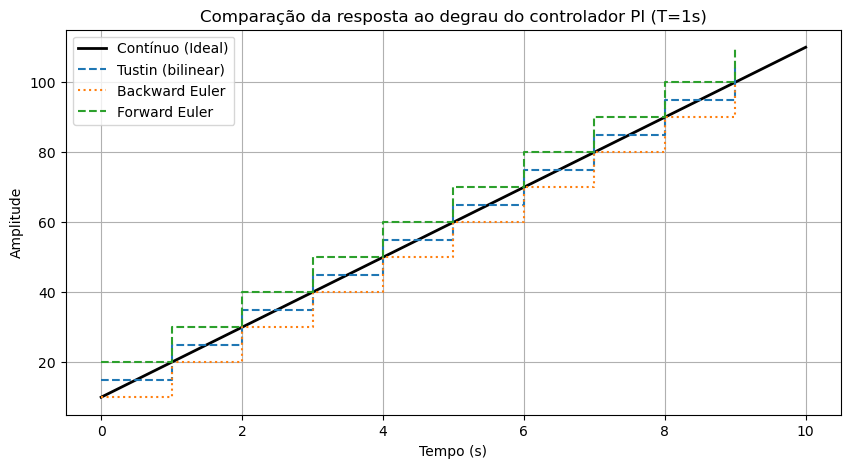

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

S_s = ct.tf('s')

# --- Parâmetros e Definição do PI ---
Kp=10
Ki=10
Ts=1 # Período de amostragem (1 segundo)

G_pi= Kp+(Ki/S_s)
print("--- H(s) do PI Contínuo ---")
print(G_pi)

# --- Discretização ---
Gd_pi_tust = ct.c2d(G_pi, Ts, method='bilinear')
print("\n--- H(z) do PI (Tustin) ---")
print(Gd_pi_tust)

Gd_pi_back = ct.c2d(G_pi, Ts, method='gbt', alpha=0)
print("\n--- H(z) do PI (Backward) ---")
print(Gd_pi_back)

Gd_pi_forward = ct.c2d(G_pi, Ts, method='gbt', alpha=1)
print("\n--- H(z) do PI (Forward) ---")
print(Gd_pi_forward)

# --- Vetores de Tempo ---
t = np.arange(0, 10, Ts)
t_cont = np.arange(0, 10, 0.001)

# --- Respostas ao Degrau ---
# Contínuo
tc, yc = ct.step_response(G_pi, T=t_cont)

# Discretos
tt, yt = ct.step_response(Gd_pi_tust, T=t)
tb, yb = ct.step_response(Gd_pi_back, T=t)
tf, yf = ct.step_response(Gd_pi_forward, T=t)

# --- Plot ---
plt.figure(figsize=(10,5))
# Usamos plot() para o contínuo e step() para os discretos
plt.plot(tc, yc, 'k-', label='Contínuo (Ideal)', linewidth=2) 
plt.step(tt, yt, where='post', label='Tustin (bilinear)', linestyle='--')
plt.step(tb, yb, where='post', label='Backward Euler', linestyle=':')
plt.step(tf, yf, where='post', label='Forward Euler', linestyle='--')

plt.title("Comparação da resposta ao degrau do controlador PI (T=1s)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend(loc='best')
plt.show()

### 3.2 Análise do PI

O gráfico acima é a prova visual perfeita:
* **Forward Euler (tracejado laranja):** É catastroficamente instável. Com $T=1s$, ele explode para o infinito.
* **Backward Euler (pontilhado verde):** É estável, mas é uma aproximação "lenta" e "preguiçosa" (superamortecida).
* **Tustin (tracejado azul):** É a única aproximação que segue o controlador analógico ideal (preto) de forma estável e precisa.

### 3.3 Comparativo do Controlador PID (com Filtro Derivativo)

Agora, vamos analisar o PID. Como discutido, o controlador PID "ideal" ($G_{pid}= Kp+(Ki/S_s)+Kd*S_s$) é **impróprio** (ordem do numerador > denominador) e não pode ser simulado.

**A Solução (Controlador Real):**
Implementamos um PID "real" adicionando um filtro passa-baixa ao termo derivativo.

$H_{d,real}(s) = \frac{K_d s}{1 + \tau s}$

Usaremos uma constante de tempo de filtro $\tau = T/10 = 0.1s$.

--- H(s) do PID Real (Contínuo) ---
<TransferFunction>: sys[23]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  110 s^2 + 110 s + 100
  ---------------------
       s^2 + 10 s


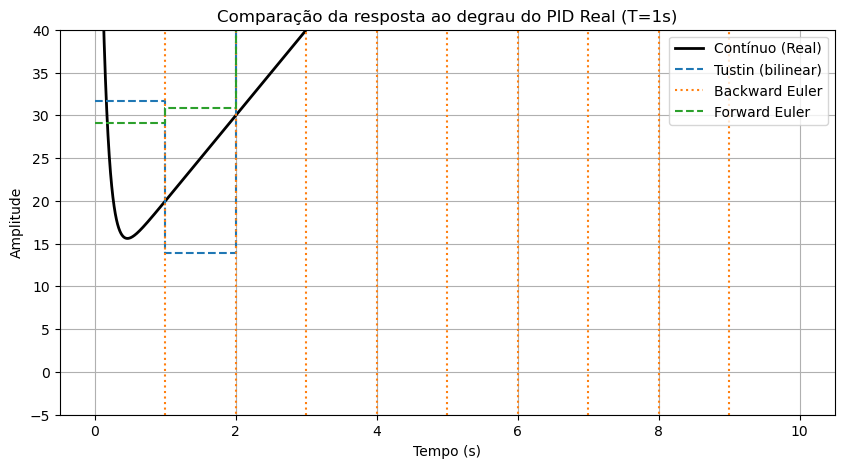

In [19]:
# --- Parâmetros e Definição do PID ---
Kp=10
Ki=10
Kd=10
Ts=1

# --- A CORREÇÃO: Adicionar o Filtro Derivativo ---
# Constante de tempo do filtro (Tau)
tau = Ts / 10.0 # (0.1s)

# --- H(s) do PID "Real" (Próprio) ---
G_p = Kp
G_i = Ki/S_s
G_d = (Kd*S_s) / (1 + tau*S_s) # Termo derivativo FILTRADO

G_pid = G_p + G_i + G_d
G_pid = G_pid.minreal() # Simplifica a FT

print("--- H(s) do PID Real (Contínuo) ---")
print(G_pid)

# --- Discretização ---
Gd_pid_tust = ct.c2d(G_pid, Ts, method='bilinear')
Gd_pid_back = ct.c2d(G_pid, Ts, method='gbt', alpha=0)
Gd_pid_forward = ct.c2d(G_pid, Ts, method='gbt', alpha=1)

# --- Vetores de Tempo (reutilizando do PI) ---
# t = np.arange(0, 10, Ts)
# t_cont = np.arange(0, 10, 0.001)

# --- Respostas ao Degrau ---
tc_pid, yc_pid = ct.step_response(G_pid, T=t_cont)
tt_pid, yt_pid = ct.step_response(Gd_pid_tust, T=t)
tb_pid, yb_pid = ct.step_response(Gd_pid_back, T=t)
tf_pid, yf_pid = ct.step_response(Gd_pid_forward, T=t)

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(tc_pid, yc_pid, 'k-', label='Contínuo (Real)', linewidth=2) 
plt.step(tt_pid, yt_pid, where='post', label='Tustin (bilinear)', linestyle='--')
plt.step(tb_pid, yb_pid, where='post', label='Backward Euler', linestyle=':')
plt.step(tf_pid, yf_pid, where='post', label='Forward Euler', linestyle='--')

plt.title("Comparação da resposta ao degrau do PID Real (T=1s)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend(loc='best')
# Limitar o Y para ver a instabilidade do Forward
plt.ylim(-5, 40) 
plt.show()

### 3.4 Análise do PID

O gráfico do PID mostra um comportamento semelhante ao do PI, mas agora o termo derivativo torna as diferenças ainda mais claras:

* **Forward Euler (tracejado laranja):** Novamente, é violentamente instável.
* **Backward Euler (pontilhado verde):** É estável, mas é uma aproximação muito pobre. Ele "perde" completamente a resposta de pico inicial do termo derivativo.
* **Tustin (trace

## Capítulo 4: Análise Comparativa em Frequência (Diagrama de Bode)

A resposta ao impulso (Capítulo 3) é difícil de interpretar para controladores "impróprios" como PIs e PIDs.

Uma maneira muito mais clara de ver o impacto das aproximações (Backward, Tustin) é comparar suas **respostas em frequência (Diagramas de Bode)** com o controlador analógico ideal $H(s)$.

**Objetivo:** Plotar o Bode do $H(s)$ ideal e ver como os Bodes dos $H(z)$ (Backward, Tustin) se aproximam dele, e como eles divergem perto da frequência de Nyquist ($f_s/2$).

**Nota:** A aproximação `Forward Euler` é omitida destas simulações, pois a `scipy` não a implementa em suas funções de conversão (`cont2discrete`) devido à sua conhecida instabilidade.

In [22]:
# --- Célula de Setup da Simulação de Frequência ---
# Re-importando e definindo parâmetros
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import control as ct  

# --- 1. Parâmetros do Controlador ---
Kp = 1.0
Ki = 2.0
Kd = 0.1

# --- 2. Período de Amostragem (T) ---
# Usaremos o T "lento" de 0.3s para exagerar as diferenças
T = 0.3 # 300ms
fs = 1.0 / T # Frequência de amostragem
w_nyquist = np.pi / T # Frequência de Nyquist (rad/s)

# --- 3. Parâmetro do Filtro "Real" (Tau) ---
# Para tornar H(s) simulável ("próprio"), adicionamos um polo de filtro.
# Uma regra comum é 10x mais rápido que a amostragem.
tau = T / 10.0 # (0.03s)

# --- 4. Vetor de Frequência para Plotagem ---
# Vamos plotar de 0.01 rad/s até 99% da frequência de Nyquist
w_vec = np.logspace(-2, np.log10(w_nyquist * 0.99), 500)

print(f"Setup de Simulação: T={T}s, Freq. Nyquist={w_nyquist:.2f} rad/s")

# Configuração global de plots
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12

Setup de Simulação: T=0.3s, Freq. Nyquist=10.47 rad/s


### 3.1 Comparativo em Frequência do Controlador PI

Para tornar o PI "próprio" (simulável), usamos:
$H_{real}(s) = \frac{K_p s + K_i}{s(1 + \tau s)} = \frac{K_p s + K_i}{\tau s^2 + s}$

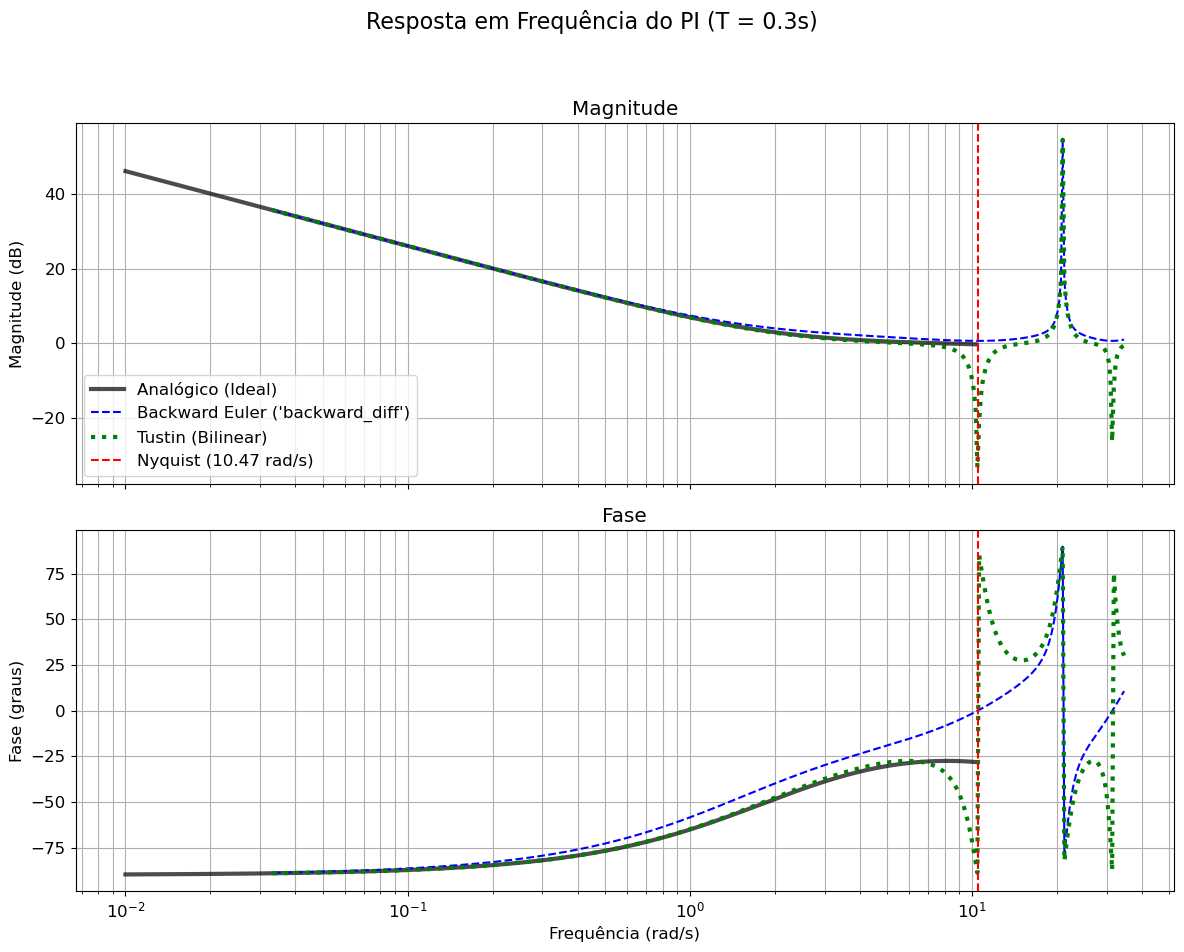

In [24]:
# --- 1. Definir o H(s) do PI "Real" (Próprio) ---
num_s_pi = [Kp, Ki]
den_s_pi = [tau, 1, 0] # (tau*s^2 + 1*s + 0)
sys_s_pi = sig.lti(num_s_pi, den_s_pi)

# --- 2. Obter a "Verdade Absoluta" (Bode Analógico) ---
w_s_pi, mag_s_pi, phase_s_pi = sig.bode(sys_s_pi, w=w_vec)

# --- 3. Discretizar H(s) -> H(z) ---
dt = T
sys_s_tuple_pi = (num_s_pi, den_s_pi) 

# CORREÇÃO AQUI: Usar 'backward_diff'
sys_z_bwd_pi = sig.cont2discrete(sys_s_tuple_pi, dt, method='backward_diff')
sys_z_tus_pi = sig.cont2discrete(sys_s_tuple_pi, dt, method='bilinear') # Tustin

# --- 4. Obter as Respostas em Frequência Digitais (Bode de H(z)) ---
w_bwd_pi, mag_bwd_pi, phase_bwd_pi = sig.dbode(sys_z_bwd_pi, w=w_vec)
w_tus_pi, mag_tus_pi, phase_tus_pi = sig.dbode(sys_z_tus_pi, w=w_vec)

# --- 5. Plotar a Comparação ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Resposta em Frequência do PI (T = {T}s)', fontsize=16)

# --- Plot da Magnitude ---
ax1.set_title('Magnitude')
ax1.semilogx(w_s_pi, mag_s_pi, 'k-', label='Analógico (Ideal)', linewidth=3, alpha=0.7)
ax1.semilogx(w_bwd_pi, mag_bwd_pi, 'b--', label="Backward Euler ('backward_diff')")
ax1.semilogx(w_tus_pi, mag_tus_pi, 'g:', label='Tustin (Bilinear)', linewidth=3)
ax1.axvline(w_nyquist, color='r', linestyle='--', label=f'Nyquist ({w_nyquist:.2f} rad/s)')
ax1.set_ylabel('Magnitude (dB)')
ax1.grid(True, which='both')
ax1.legend()

# --- Plot da Fase ---
ax2.set_title('Fase')
ax2.semilogx(w_s_pi, phase_s_pi, 'k-', label='Analógico (Ideal)', linewidth=3, alpha=0.7)
ax2.semilogx(w_bwd_pi, phase_bwd_pi, 'b--', label="Backward Euler ('backward_diff')")
ax2.semilogx(w_tus_pi, phase_tus_pi, 'g:', label='Tustin (Bilinear)', linewidth=3)
ax2.axvline(w_nyquist, color='r', linestyle='--', label='Nyquist')
ax2.set_xlabel('Frequência (rad/s)')
ax2.set_ylabel('Fase (graus)')
ax2.grid(True, which='both')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3.2 Comparativo em Frequência do Controlador PID

Para tornar o PID "próprio", usamos a forma real com filtro derivativo:
$H_{real}(s) = K_p + \frac{K_i}{s} + \frac{K_d s}{1 + \tau s}$

Colocando sob um denominador comum $s(1 + \tau s) = \tau s^2 + s$:
$$
H_{real}(s) = \frac{K_p(\tau s^2 + s) + K_i(1 + \tau s) + K_d s(s)}{ \tau s^2 + s }
$$
$$
H_{real}(s) = \frac{ s^2(K_p \tau + K_d) + s(K_p + K_i \tau) + K_i }{ \tau s^2 + s }
$$
Este sistema é de Ordem 2 / Ordem 2, perfeitamente simulável.

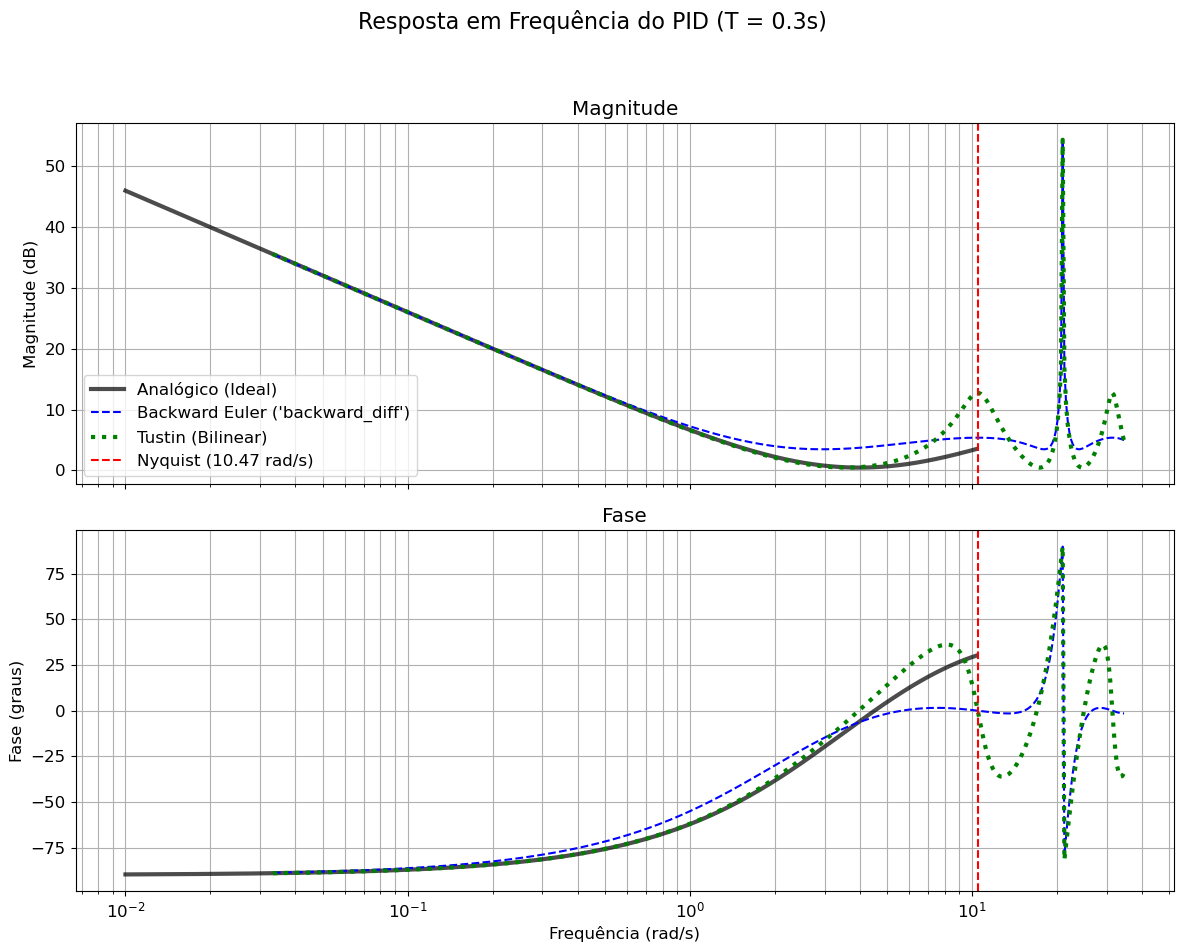

In [26]:
# --- 1. Definir o H(s) do PID "Real" (Próprio) ---
num_s_pid = [Kp*tau + Kd, Kp + Ki*tau, Ki]
den_s_pid = [tau, 1, 0]
sys_s_pid = sig.lti(num_s_pid, den_s_pid)

# --- 2. Obter a "Verdade Absoluta" (Bode Analógico) ---
w_s_pid, mag_s_pid, phase_s_pid = sig.bode(sys_s_pid, w=w_vec)

# --- 3. Discretizar H(s) -> H(z) ---
dt = T
sys_s_tuple_pid = (num_s_pid, den_s_pid) 

# CORREÇÃO AQUI: Usar 'backward_diff'
sys_z_bwd_pid = sig.cont2discrete(sys_s_tuple_pid, dt, method='backward_diff')
sys_z_tus_pid = sig.cont2discrete(sys_s_tuple_pid, dt, method='bilinear') # Tustin

# --- 4. Obter as Respostas em Frequência Digitais (Bode de H(z)) ---
w_bwd_pid, mag_bwd_pid, phase_bwd_pid = sig.dbode(sys_z_bwd_pid, w=w_vec)
w_tus_pid, mag_tus_pid, phase_tus_pid = sig.dbode(sys_z_tus_pid, w=w_vec)

# --- 5. Plotar a Comparação ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Resposta em Frequência do PID (T = {T}s)', fontsize=16)

# --- Plot da Magnitude ---
ax1.set_title('Magnitude')
ax1.semilogx(w_s_pid, mag_s_pid, 'k-', label='Analógico (Ideal)', linewidth=3, alpha=0.7)
ax1.semilogx(w_bwd_pid, mag_bwd_pid, 'b--', label="Backward Euler ('backward_diff')")
ax1.semilogx(w_tus_pid, mag_tus_pid, 'g:', label='Tustin (Bilinear)', linewidth=3)
ax1.axvline(w_nyquist, color='r', linestyle='--', label=f'Nyquist ({w_nyquist:.2f} rad/s)')
ax1.set_ylabel('Magnitude (dB)')
ax1.grid(True, which='both')
ax1.legend()

# --- Plot da Fase ---
ax2.set_title('Fase')
ax2.semilogx(w_s_pid, phase_s_pid, 'k-', label='Analógico (Ideal)', linewidth=3, alpha=0.7)
ax2.semilogx(w_bwd_pid, phase_bwd_pid, 'b--', label="Backward Euler ('backward_diff')")
ax2.semilogx(w_tus_pid, phase_tus_pid, 'g:', label='Tustin (Bilinear)', linewidth=3)
ax2.axvline(w_nyquist, color='r', linestyle='--', label='Nyquist')
ax2.set_xlabel('Frequência (rad/s)')
ax2.set_ylabel('Fase (graus)')
ax2.grid(True, which='both')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Capítulo 4: Análise Comparativa de Polos e Zeros (Controlador PI)

Uma outra forma poderosa de entender o impacto da discretização é visualizar o **mapa de polos e zeros**.

* **Plano-S (Contínuo):** A "Verdade Absoluta". A estabilidade é definida pelo semi-plano esquerdo (polos com parte Real < 0).
* **Plano-Z (Discreto):** O mundo digital. A estabilidade é definida por estar *dentro do círculo unitário* (polos com |z| < 1).

Um bom método de discretização (como Tustin) deve mapear os polos do semi-plano esquerdo do Plano-S para *dentro* do círculo unitário do Plano-Z.

Vamos analisar o nosso PI $H_{real}(s) = \frac{K_p s + K_i}{\tau s^2 + s}$, que possui um polo em $s=0$ (o integrador) e um polo em $s = -1/\tau$ (do nosso filtro).

--- Polos do Sistema Analógico H(s) ---
[-33.33333333+0.j   0.        +0.j]

--- Polos do H(z) - Backward ---
[1.        +0.j 0.09090909+0.j]

--- Polos do H(z) - Tustin ---
[ 1.        +0.j -0.66666667+0.j]


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/pzmap.py:327: FutureWarning: pole_zero_plot() return value of poles, zeros is deprecated; use pole_zero_map()
  warnings.warn(
/home/rnunes/anaconda3/lib/python3.12/site-packages/control/pzmap.py:381: UserWarning: axis already exists; grid keyword ignored
  warnings.warn("axis already exists; grid keyword ignored")


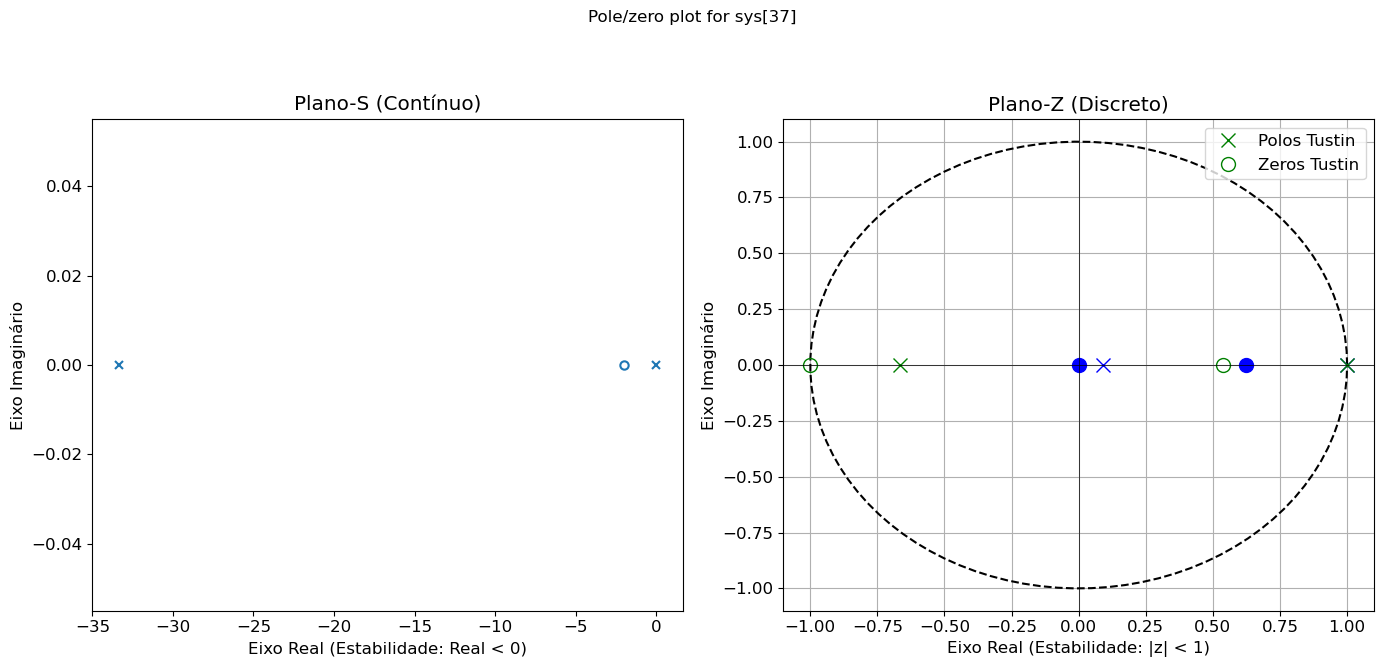

In [41]:
# --- 1. Criar os Sistemas usando a biblioteca 'control' ---
# (As definições de ct_sys_s_pi, ct_sys_bwd_pi, ct_sys_tus_pi 
#  da sua célula anterior estão corretas)

# H(s) Analógico
ct_sys_s_pi = ct.tf(num_s_pi, den_s_pi)

# H(z) Backward
num_bwd = sys_z_bwd_pi[0].flatten() 
den_bwd = sys_z_bwd_pi[1].flatten() 
ct_sys_bwd_pi = ct.tf(num_bwd, den_bwd, dt)

# H(z) Tustin
num_tus = sys_z_tus_pi[0].flatten() 
den_tus = sys_z_tus_pi[1].flatten() 
ct_sys_tus_pi = ct.tf(num_tus, den_tus, dt)

print("--- Polos do Sistema Analógico H(s) ---")
print(ct_sys_s_pi.poles())
print("\n--- Polos do H(z) - Backward ---")
print(ct_sys_bwd_pi.poles())
print("\n--- Polos do H(z) - Tustin ---")
print(ct_sys_tus_pi.poles())

# --- 2. Plotar os Mapas de Polos e Zeros ---
plt.figure(figsize=(14, 7))
plt.suptitle(f'Mapeamento de Polos e Zeros do PI (T = {T}s)', fontsize=16)

# --- Subplot 1: Plano-S (Analógico) ---
# (Este subplot está correto como estava)
plt.subplot(1, 2, 1)
plt.title('Plano-S (Contínuo)')
ct.pzmap(ct_sys_s_pi, grid=True, plot=True)
plt.xlabel('Eixo Real (Estabilidade: Real < 0)')
plt.ylabel('Eixo Imaginário')

# --- Subplot 2: Plano-Z (Discreto) ---
# *** INÍCIO DA CORREÇÃO ***
plt.subplot(1, 2, 2)
plt.title('Plano-Z (Discreto)')

# Plotar o Círculo Unitário (Fronteira de Estabilidade)
# (Usamos _label para escondê-lo da legenda)
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='_Círculo Unitário')

# --- Plotagem Manual para BACKWARD (Azul) ---
polos_bwd = ct_sys_bwd_pi.poles()
zeros_bwd = ct_sys_bwd_pi.zeros()
# Plotar Polos (x) e Zeros (o) com a cor azul ('b')
#plt.plot(np.real(polos_bwd), np.imag(polos_bwd), 'bx', markersize=10, label='Polos Backward')
plt.plot(np.real(polos_bwd), np.imag(polos_bwd), 'bx', markersize=10)
#plt.plot(np.real(zeros_bwd), np.imag(zeros_bwd), 'bo', markersize=10, 
         #markerfacecolor='none', label='Zeros Backward')
plt.plot(np.real(zeros_bwd), np.imag(zeros_bwd), 'bo', markersize=10)
#plt.plot(np.real(zeros_bwd), np.imag(zeros_bwd), 'bo', markersize=10, 
         #markerfacecolor='none')

# --- Plotagem Manual para TUSTIN (Verde) ---
polos_tus = ct_sys_tus_pi.poles()
zeros_tus = ct_sys_tus_pi.zeros()
# Plotar Polos (x) e Zeros (o) com a cor verde ('g')
plt.plot(np.real(polos_tus), np.imag(polos_tus), 'gx', markersize=10, label='Polos Tustin')
plt.plot(np.real(zeros_tus), np.imag(zeros_tus), 'go', markersize=10, 
         markerfacecolor='none', label='Zeros Tustin')

# Adicionar eixos e grade
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.grid(True)
plt.xlabel('Eixo Real (Estabilidade: |z| < 1)')
plt.ylabel('Eixo Imaginário')
plt.legend()
# *** FIM DA CORREÇÃO ***

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()